In [1]:
import importlib 
import utils
import os
import json
import pandas as pd
importlib.reload(utils)

<module 'utils' from '/home/miaoran/FaithBench/assign/utils.py'>

In [2]:
# from batch ID to the corresponding sample IDs
skip_samples = {
    5: range(40, 50), 
    10: range(10,20),
    12: range(20, 30), 
    15: range(40, 50)
}

annotator_list = {
    7: ['yujia', 'manveer'],
    8: ['miaoran', 'chenyu'],
    # 11: ['rogger', 'matt'] #'yujia',
}

three_annotators = [3,5]

halu_labels_list = [['Unwanted'], ['Unwanted', 'Questionable'], ['Unwanted', 'Questionable', 'Benign']]

In [3]:
result_path = 'batch_5_src_no_sports/results'
result_files = []
skip_sample_ids = {}
selected_annotators = {}
num_annotators = {}

for batch_id in range(1,16+1):
    file_name = os.path.join(result_path, f"batch_{batch_id}_annotation.json")
    result_files.append(file_name)
    if batch_id in skip_samples:
        skip_sample_ids[file_name] = skip_samples[batch_id]
    if batch_id in annotator_list:
        selected_annotators[file_name] = annotator_list[batch_id]
    if batch_id in three_annotators:
        num_annotators[file_name] = 3
    else:
        num_annotators[file_name] = 2
 
for halu_labels in halu_labels_list:
    # Get three variables
    # halu_eval-U: evaluator with ['Unwanted'] as hallucination labels
    # halu_eval-UQ: evaluator with ['Unwanted', 'Questionable'] as hallucination labels
    # halu_eval-UQB: evaluator with ['Unwanted', 'Questionable', 'Benign'] as hallucination labels
    globals()["halu_eval-" + ''.join([label[0] for label in halu_labels])]= utils.HaluEvaluator(result_files, halu_labels=halu_labels, skip_sample_ids=skip_sample_ids, selected_annotators=selected_annotators, num_annotators=num_annotators)
    locals()["halu_eval-" + ''.join([label[0] for label in halu_labels])].process_results()
   

## Hallucination Ranking Table

In [4]:
# Get halu rate
halu_rate_results = {}
for halu_labels in halu_labels_list:
    halu_result = locals()["halu_eval-" + ''.join([label[0] for label in halu_labels])].compute_halu_rate()
    for model, rate in halu_result.items():
        if model not in halu_rate_results:
            halu_rate_results[model] = []
        halu_rate_results[model].append(rate)
halu_rate_results_df = pd.DataFrame.from_dict(halu_rate_results, orient='index', columns=['-'.join(halu_labels) for halu_labels in halu_labels_list])

# Get ranking df
df_ranked = halu_rate_results_df.copy()
## Apply ranking for each column in reverse order
for column in df_ranked.columns:
    df_ranked[column] = df_ranked[column].astype(float).rank(ascending=True, method='min').astype(int)

# Combine original scores with ranks in the desired format
df_combined = halu_rate_results_df.applymap(str) + "/" + df_ranked.applymap(str)
df_combined


/tmp/ipykernel_13859/3975124604.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_combined = halu_rate_results_df.applymap(str) + "/" + df_ranked.applymap(str)


,Unwanted,Unwanted-Questionable,Unwanted-Questionable-Benign
GPT-4o,34.09/1,43.18/1,54.55/1
Llama-3.1-70B,45.45/2,54.55/3,61.36/3
GPT-3.5-Turbo,47.73/3,52.27/2,59.09/2
Claude-3.5-Sonnet,47.73/3,59.09/4,81.82/8
Llama-3.1-8B,54.55/5,65.91/6,72.73/5
Gemini-1.5-Flash,56.82/6,59.09/4,65.91/4
Phi-3-mini-4k,59.09/7,68.18/7,72.73/5
Qwen2.5-7B,68.18/8,75.0/8,79.55/7
Command-R,72.73/9,79.55/9,90.91/10
Mistral-7B,75.0/10,79.55/9,84.09/9


## Annotation-level disttribution of annotation labels for the three hallucination labels only

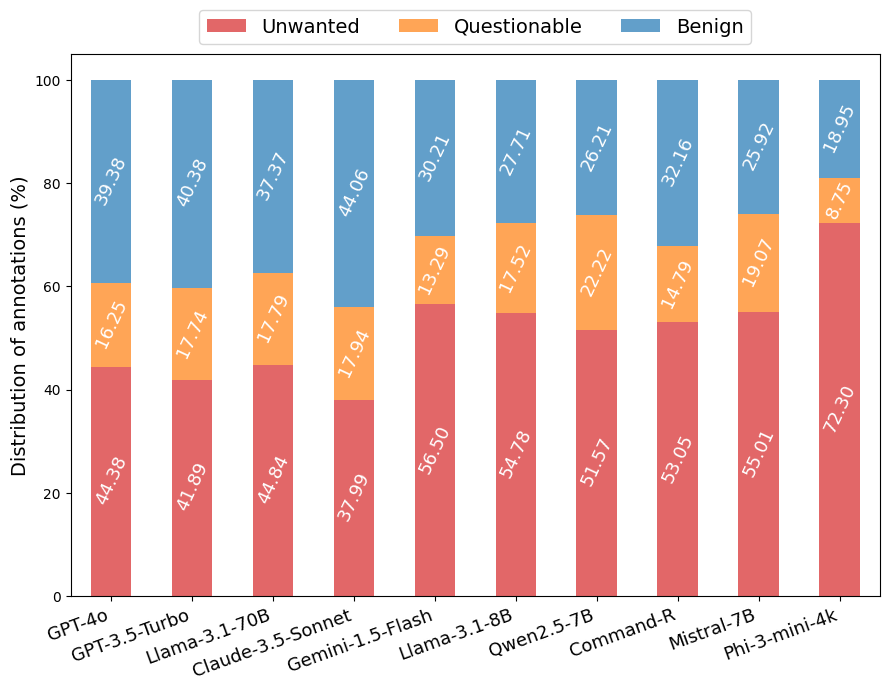

In [5]:
halu_eval = locals()["halu_eval-U"] # If you want use ['Unwanted', 'Questionable']/['Unwanted', 'Questionable','Benign'] as halu_labels, just replace -U with -UQ / -UQB
halu_eval.get_annotation_dist()

## Sample-level final label desitribuiton

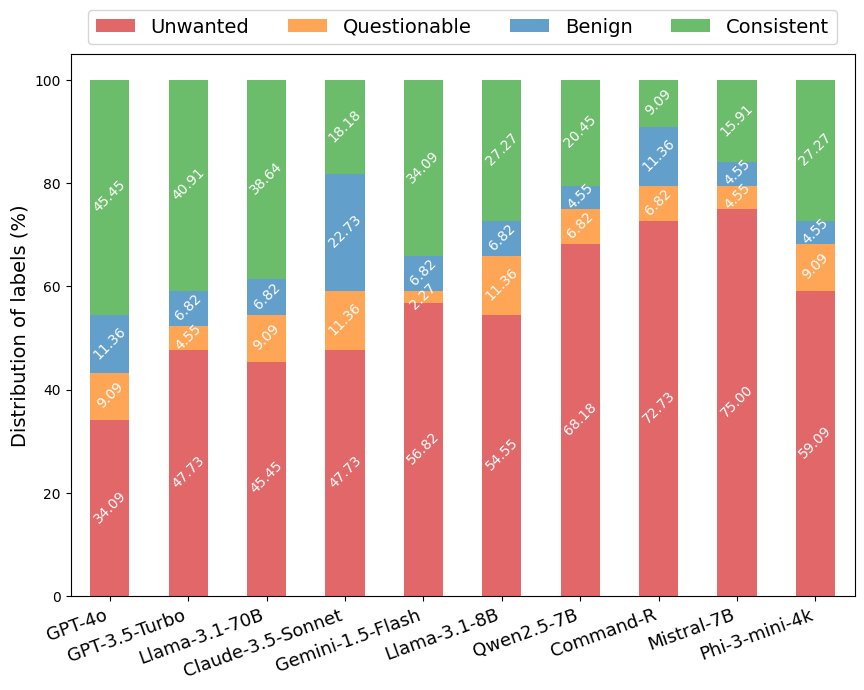

In [6]:
halu_eval.get_sample_dist()

## Hallucination rates vs. passage length

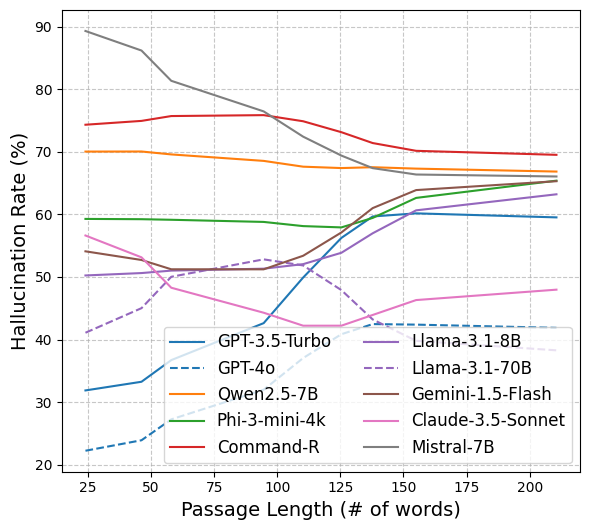

In [7]:
halu_eval.halu_vs_length('source')

## Hallucination rates vs. summary length

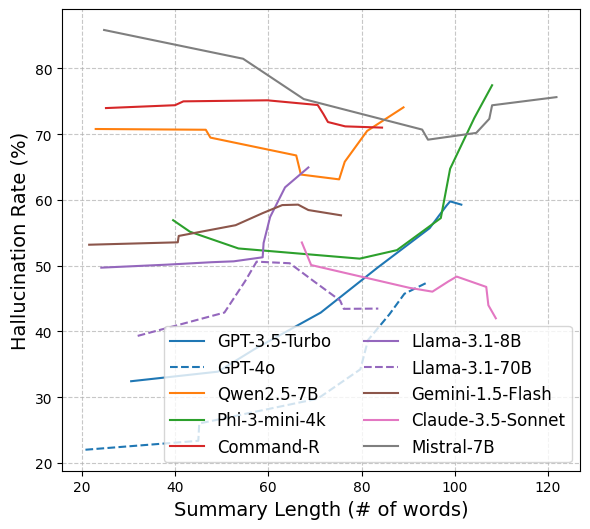

In [8]:
halu_eval.halu_vs_length('summary')

## avg. annotation count vs. passage length 
avg. annotation count: for each sample, number of a label / number of annotators

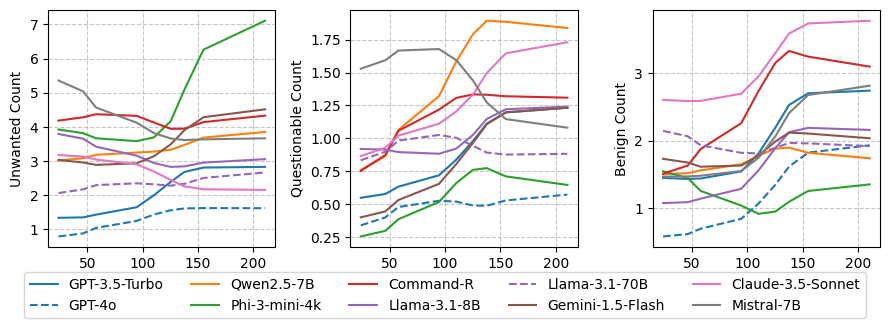

In [9]:
halu_eval.label_vs_length(mode = 'count', length_of='source')

## annotation ratio vs. passage length

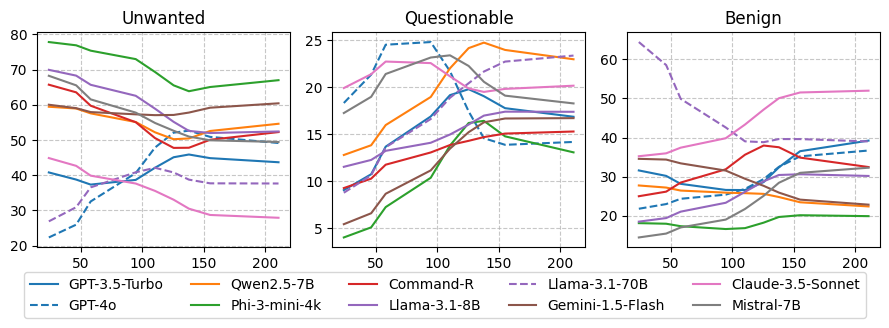

In [10]:
halu_eval.label_vs_length(mode = 'ratio', length_of='source')